# Normal mode measurement
This will download seismic waveforms & measure sensor orientation for a target station. ObsPy, numpy, scipy, matplotlib are required.

## Import ObsPy module

In [1]:
from obspy import read
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth

import obspy as ob
print("# obspy version = ",ob.__version__)

# obspy version =  1.2.2


## Import SciPy, NumPy, matplotlib module

In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl

print("# numpy version = ",np.__version__)
print("# scipy version = ",sp.__version__)
print("# matplotlib version = ",mpl.__version__)

import matplotlib.pyplot as plt

from scipy import signal


import sys
import os


# numpy version =  1.19.1
# scipy version =  1.5.2
# matplotlib version =  3.3.1


## Font size

In [3]:
# font size
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#SMALL_SIZE = 32
#MEDIUM_SIZE = 32
#BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## function: get_seedid
to extract seed_id from obspy stream.

In [4]:
def get_seedid (tr):
    seedid=tr.stats.network+"."+tr.stats.station+"."+tr.stats.location+"."+tr.stats.channel
    return seedid

## function: st_remove_resp
to correct instrument response.

In [5]:
def st_remove_resp (st, deciopt, decifactor, pre_filt, output):
    st.detrend() # remove linear trend
    st.detrend("demean") # demean
    st.taper(0.05) # cosin taper

    if deciopt == 1:
        # decimate to 100Hz
        if decifactor == 100:     
            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

        else:
            st.decimate(factor=decifactor, strict_length=False)
    
    st = st.remove_response(pre_filt=pre_filt,output=output,water_level=None) # get velocity data (m/s)

    return st


## function: get_sta_coord
to extract station coordinate from obspy stream.

In [6]:
def get_sta_coord (seedid, inv, starttime):
    sta_coordinate = inv.get_coordinates(seedid, starttime)
    return sta_coordinate


## function: get_baz
to compuete back-azimuth

In [7]:
#def get_baz (st, inv, evla, evlo):
def get_baz (tr, inv, evla, evlo):

    #seedid=get_seedid(st[0])
    seedid=get_seedid(tr)

    sta_coord = get_sta_coord(seedid,inv,starttime)
    
    stla = sta_coord['latitude']
    stlo = sta_coord['longitude']
    
    source_latitude = evla
    source_longitude = evlo
    
    station_latitude = stla
    station_longitude = stlo
    
    # theoretical backazimuth and distance
    baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

    #print('Epicentral distance [m]: ', baz[0])
    #print('Theoretical azimuth [deg]: ', baz[1])
    #print('Theoretical backazimuth [deg]: ', baz[2])
    
    return baz

## Spheroidal mode


In [8]:
spheroidal_mode_mHz = np.array( [0.30945, 0.46850, 0.64682, 0.84002, 1.03755, 1.23105, 1.41285, 1.57755, 1.72560, 1.86130, 1.98900, 2.11158, 2.22980, 2.34495, 2.45690, 2.56580, 2.67250, 2.77610, 2.87795, 2.97730, 3.07470, 3.17070, 3.26550, 3.35885, 3.45135, 3.54310, 3.63420, 3.72470, 3.81480, 3.90470, 3.99400, 4.08350, 4.17250, 4.26170, 4.35110, 4.44020, 4.52950, 4.61890, 4.70840, 4.79810, 4.88790, 4.97770, 5.06760, 5.15790, 5.24820, 5.33850, 5.42900, 5.51950, 5.61030, 5.70160, 5.79250, 5.88380, 5.97510, 6.06650, 6.15830, 6.25000, 6.34180, 6.43380, 6.52600, 6.98900, 7.45500, 7.92500, 8.39300, 8.86700, 9.33900, 9.81300, 10.28900, 11.24700, 12.20500, 13.16500, 14.13500, 15.11000, 16.07800, 17.04800, 18.01900, 18.98900, 19.95800] )


## Set client (Data Center) for event search
This example uses USGS. We can use other dataceneter (e.g., NCEDC, IRIS)

In [9]:
#clientEQ = Client("IRIS")
clientEQ = Client("USGS")

## Event search
Set time window (st, et) and a range of magunitude (minmag, maxmag). This example will find the 15 October 2020 M 2.6 Pleasant Hill event.

1 Event(s) in Catalog:
2010-02-27T06:34:11.530000Z | -36.122,  -72.898 | 8.8 mww | manual


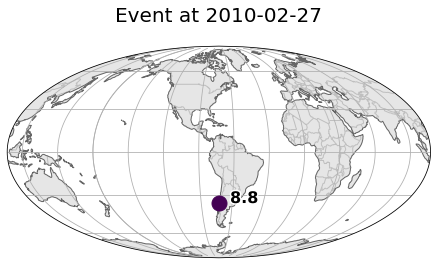

In [10]:
#M 8.8 - offshore Bio-Bio, Chile
#2010-02-27 06:34:11 (UTC)36.122°S 72.898°W22.9 km depth
#https://earthquake.usgs.gov/earthquakes/eventpage/official20100227063411530_30/executive

st = UTCDateTime("2010-02-27T00:00:00")  # 
et = UTCDateTime("2010-02-28T00:00:00")  #
minmag = 8.5
maxmag = 9.0       

catalog = clientEQ.get_events(starttime=st , endtime=et,
                            minmagnitude=minmag, maxmagnitude=maxmag)
print(catalog)

_plot = catalog.plot()


## Extract event information


In [11]:
# event info. origin time, location, magnitude
event = catalog[0]
origin = event.origins[0]
origin_time = origin.time
evla = origin.latitude
evlo = origin.longitude
evdp_km = origin.depth / 1000
evmag = event.magnitudes[0].mag

evyearOUT = origin_time.year
evjdayOUT = origin_time.julday
evhourOUT = origin_time.hour
evminOUT = origin_time.minute
evsecOUT = origin_time.second

evid = event.origins[0]['extra']['dataid']['value']
event_region = event.event_descriptions[0]['text']

#print("# evid = ",evid)
#print("# event_region = ",event_region)

In [12]:
# need for file name
evyearOUT2 = (str)(evyearOUT)
evjdayOUT2 = (str)(evjdayOUT)
if evjdayOUT < 100:
    evjdayOUT2 = "0"+(str)(evjdayOUT)
        

if evjdayOUT < 10:
    evjdayOUT2 = "00"+(str)(evjdayOUT)
    

evhourOUT2 = (str)(evhourOUT)
if evhourOUT < 10:
    evhourOUT2 = "0"+(str)(evhourOUT)
        

evminOUT2 = (str)(evminOUT)
if evminOUT < 10:
    evminOUT2 = "0"+(str)(evminOUT)


evsecOUT2 = (str)(evsecOUT)
if evsecOUT < 10:
    evsecOUT2 = "0"+(str)(evsecOUT)
        
        
#print("# evyearOUT2 = ",evyearOUT2," evjdayOUT2 = ",evjdayOUT2," evhourOUT2 = ",evhourOUT2," evminOUT2 = ",evminOUT2," evsecOUT2 = ",evsecOUT2)
    
evmseedid = evyearOUT2+"."+evjdayOUT2+"."+evhourOUT2+""+evminOUT2+""+evsecOUT2
#print("# evmseedid = "+evmseedid)

event_para = evmseedid +"_M"+(str)(evmag)+"_"+(str)(evid)


## Directory for waveform plot
This example will create directory "2010.058.063411_M8.8_official20100227063411530_30" where all plots will be saved.

In [13]:
# name for output directory
pwd_dir = os.getcwd() 
#sacdir= pwd_dir +"/"+ evmseedid +"_M"+(str)(evmag)+"_"+(str)(eventid_ncedc)+"_fl"+(str)(f2)+"_fh"+str(f3)+"_dist"+(str)(distkm_from_eq)+"km"
#plot_dir= pwd_dir +"/"+ evmseedid +"_M"+(str)(evmag)+"_"+(str)(evid)
#+"_fl"+(str)(f2)+"_fh"+str(f3)+"_dist"+(str)(distdeg_from_eq)+"deg"


plot_dir= pwd_dir +"/"+ event_para

print("# plot_dir = ",plot_dir)

# create output directory
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


# plot_dir =  /Users/taira/work/python_work/2010.058.063411_M8.8_official20100227063411530_30


## Set time window for downloading seismic data
This example extracts 5-day data for the 2010 M 8.8 Chile earthquake

In [14]:
pre_tw = 0 # 0s if this is -10, then data from -10s from the origin time
stw_day = 5 # 5-day from the starting time (oriting_time + pre_tw)

stw = stw_day*24*60*60 # 5 day 

starttime = origin_time + pre_tw  
endtime = starttime + stw


## Set parameters for Welch spectral estimation
This example use 1.0-day-long data with 75% overlapping for Welch spetracal estimation

In [15]:
# def
#w_length_day = 0.5 # days
w_length_day = 1.0 # days

overlap = 0.75 # 75%
overlap_percent = overlap*100

w_length_hour = w_length_day  * 24
stw_hour = stw_day* 24

In [16]:
welch_para = "Total "+str(stw_hour)+"-hour-long data. Amplitude spectra: "+str(w_length_hour)+"-hour time window with "+str(overlap_percent)+"% overlapping"
print("# welch_para = ", welch_para)


# welch_para =  Total 120-hour-long data. Amplitude spectra: 24.0-hour time window with 75.0% overlapping


## Set SNCL parameters
Which SNCL (Station, Network, Component, Location) we will use? sta1,net1,com1,loc1 for the target data, sta2,net2,com2,loc2 for the reference data.

In [17]:
# targert
sta1 = "*" # all station
net1 = "BK" # network
com1 = "BHZ,BH1" # component "HH?" to get all 3-com data from broadband sensor

loc1 = "*" # location

deciopt_1 = 1
decifactor_1 = 10 # 40sps -> 4 sps

client1 = Client("NCEDC") # data from NCEDC

## Set frequency range for sensor orientation
Set the frequency range (fl and fh) for sensor orientation measurements. This example will use 0.5 mHz-5.0 Hz band. Also this will use for pre-filter when we correct the instrument response.

In [18]:
#fl2 < fl < fh < fh2
fl2 = 1e-4 #Hz
fl =  5e-4 # Hz 
fh = 5.0 #  Hz
fh2 = 6.0 # Hz

#pre_filt = [0.015, 0.02, 45, 50]
pre_filt = [fl2, fl, fh, fh2]

## Set frequency range for plotting
use 1mHz-5.5mHz range to plot amplitude spetra. flabel_pl is the frequency where we plot "station name". 

In [19]:
fl_pl = 1e-3 # Hz fl for plotting
fh_pl = 5.5e-3 # Hz fh for plotting
flabel_pl = 0.78e-3 # hz for station label position



## Set value to normalize amplitude spectra


In [20]:
norm_val = 2.5e-6
#norm_val = 1.5e-7
#norm_val = 3.5e-6

## Downloading seismic data
use get_waveforms to download data and do st.plot() for plotting. Also use get_stsations to obtation station inventory file. 

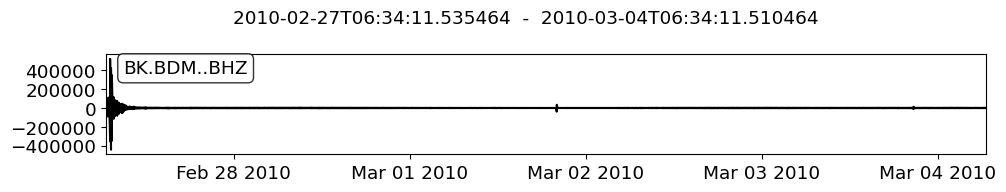

In [21]:
st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)
inv1 = client1.get_stations(network=net1, station=sta1, location=loc1, channel=com1,
                     starttime=starttime, endtime=endtime, 
                     level="response")

#_plot = st1.plot(size=(1000,600))
# check only first trace
_plot = st1[0].plot(size=(1000,200))

#_plot = st1.plot()


## Removing instrument response 
use st_remove_resp function uses obspy remove_response to remove instrument response. Example will provide ground acceleration data (m/s**2)

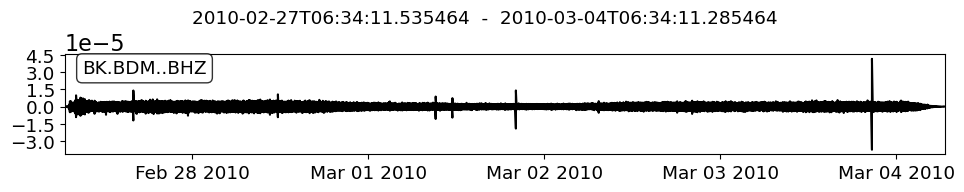

In [22]:
st1_gm = st_remove_resp(st1.copy(), deciopt_1, decifactor_1, pre_filt, "ACC")

_plot = st1_gm[0].plot(size=(1000,200))

In [23]:
#st1_merge = st1.copy().merge()

# add zero
#st1_merge = st1_gm.copy().merge(fill_value=0)
# just merge. need to check if gaps are there

st1_merge = st1_gm.copy()
#print(st1_merge)

## Checking if each segment has enough data points

In [24]:
for tr in st1_merge:
    npts_out=tr.stats.npts
    sta_out = tr.stats.station
    sampling_rate_out = tr.stats.sampling_rate
    npts_out = tr.stats.npts
    #print("# sta_out = ", sta_out, " npts_out = ", npts_out)
    w_length = int(w_length_day * 60 * 60 * 24 * sampling_rate_out)
    #print("# sampling_rate_out = ",sampling_rate_out," w_lengh = ", w_length)
    
    # to comput % of data gap
    total_length = int(stw_day * 60 * 60 * 24 * sampling_rate_out)
    #print("# total_length = ", total_length)
    #print("# npts_out = ", npts_out)

    seedid_out = get_seedid(tr)
    #print("# seedid_out = ", seedid_out)
    
    #if sta_gap_count.get(seedid_out) == None:
    #    print("# no gap")
    #else:
    #    print("# gap")
    
    #best_az1_min = "{:.2f}".format(min_az_resi_energy)
    total_percent = "{:.2f}".format((npts_out / total_length ) * 100.0)
    #print("# total_percent = ", total_percent)
    tr.stats.total_percent = total_percent
    tr.stats.total_length =  total_length
    if npts_out < w_length:
        print("# ",sta_out, " trace removed. Data point (npts_out) is less than the length of window: npts = ", npts_out, " w_length = ", w_length)
        st1_merge.remove(tr)


#  BRK  trace removed. Data point (npts_out) is less than the length of window: npts =  292984  w_length =  345600
#  BRK  trace removed. Data point (npts_out) is less than the length of window: npts =  169936  w_length =  345600
#  FARB  trace removed. Data point (npts_out) is less than the length of window: npts =  115289  w_length =  345600
#  FARB  trace removed. Data point (npts_out) is less than the length of window: npts =  34607  w_length =  345600
#  FARB  trace removed. Data point (npts_out) is less than the length of window: npts =  27142  w_length =  345600
#  FARB  trace removed. Data point (npts_out) is less than the length of window: npts =  271062  w_length =  345600
#  FARB  trace removed. Data point (npts_out) is less than the length of window: npts =  93065  w_length =  345600
#  FARB  trace removed. Data point (npts_out) is less than the length of window: npts =  181253  w_length =  345600
#  FARB  trace removed. Data point (npts_out) is less than the length of wind

In [25]:
#st1_merge = st1_merge.merge()
st1_merge = st1_merge.copy().merge(fill_value=0)


## Computing Welch spectra

In [26]:
for tr in st1_merge:
    #print("# tr = ",tr)
    delta = tr.stats.delta
    sta_out = tr.stats.station
    npts_out = tr.stats.npts
    sampling_rate_out = tr.stats.sampling_rate
    #print("# sta_out = ", sta_out, " npts_out = ", npts_out)
    w_length = int(w_length_day * 60 * 60 * 24 * sampling_rate_out)
    #print("# sampling_rate_out = ",sampling_rate_out," w_lengh = ", w_length)

    nperseg = w_length
    noverlap = int(w_length * overlap)

    freq, p11 = signal.welch(tr, 1/delta, nperseg=nperseg, noverlap=noverlap)
    tr.fdata = p11
    tr.freq = freq
    #print("# tr.fdata = ",tr.fdata)
    

## Estimating event-station distance and sorting out of traces

In [27]:
for tr in st1_merge:
    baz1 = get_baz(tr, inv1, evla, evlo)
    #print("# baz1[0] = ", baz1[0])
    evdist_km = baz1[0]/1000.0
    tr.stats.evdist_km = evdist_km
    #print("# evdist_km = ",evdist_km)

    

In [28]:
#self.traces.sort(key=lambda x: x.stats[_i], reverse=reverse)
st1_merge.traces.sort(key=lambda x: x.stats.evdist_km, reverse=False)
#print(st1_merge)

## Plotting amplitude spectra

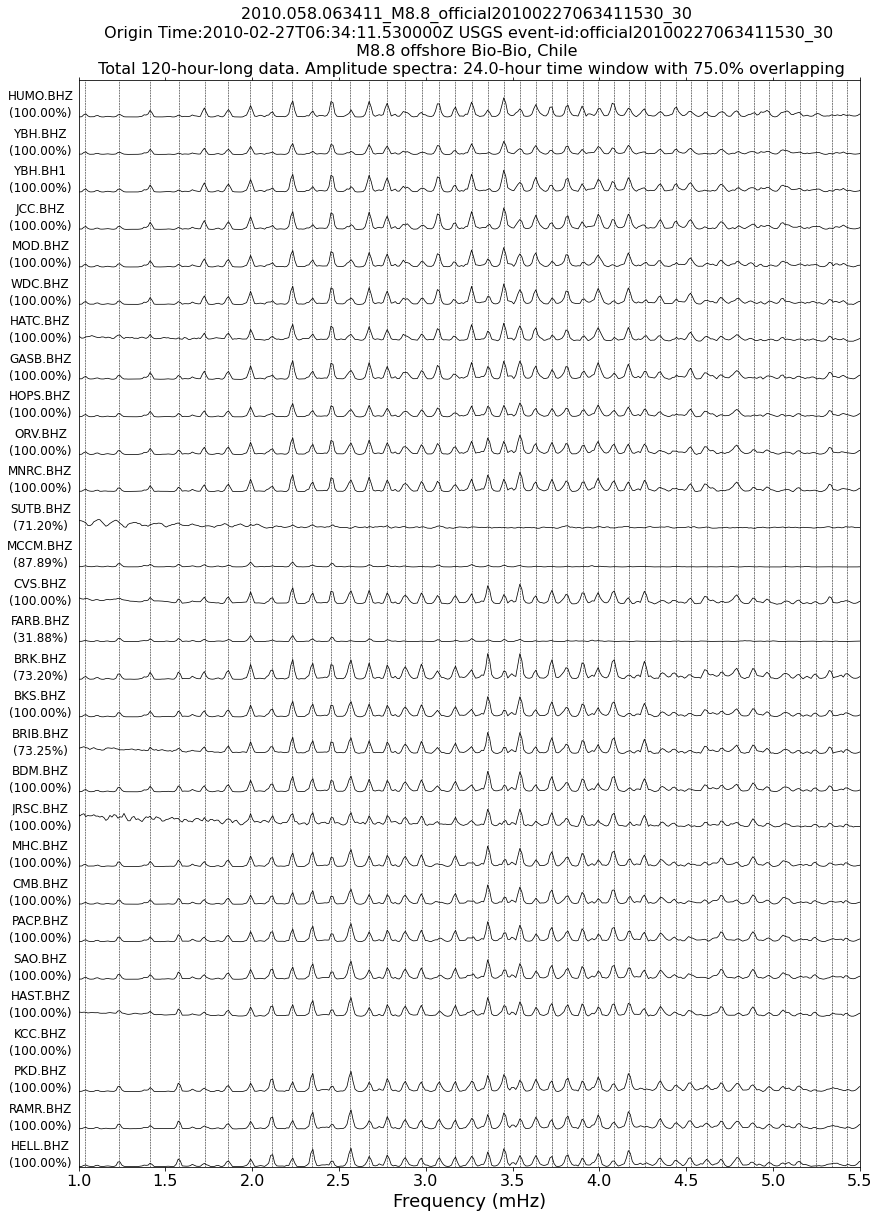

In [29]:
plot_fi = plot_dir+"/plot_normal_mode_"+event_para+".pdf"
#print("# plot_fi = ", plot_fi)

#plt.rcParams['figure.figsize'] = 14, 18
fig = plt.figure(figsize=(14,20)) 
st_num = len(st1_merge)


plt.title(event_para+" \n Origin Time:"+str(origin_time)+" USGS event-id:"+evid \
          +" \n M"+str(evmag)+" "+event_region\
          +"  \n "+welch_para)
plt.vlines(x=spheroidal_mode_mHz/1000.0, ymin=0, ymax=st_num, color="black", linewidth = 0.5, linestyle = "--")


i = 0

for tr in st1_merge:
    # def
    #seedid_out = get_seedid(tr)
    #print("# seedid_out = ", seedid_out)
    
    yval=(np.sqrt(tr.fdata)/norm_val) + i

    yval = np.where( (1+i) < yval, None,  yval)
     
    # def
    plt.plot(tr.freq, yval, color="black", linewidth = 0.75, linestyle = "solid")

    ylabel_pl = 0.45 + i
    sta=tr.stats.station
    com=tr.stats.channel
    sta_para = sta+"."+com
    
    t=plt.text(flabel_pl, ylabel_pl, sta_para, ha='center', fontsize=12)
    #pyplot.text(x, y, s)
    t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
   
    ylabel_pl2 = 0.0 + i
    total_percent = tr.stats.total_percent
    t=plt.text(flabel_pl, ylabel_pl2, "("+total_percent+"%)", ha='center', fontsize=12)
    #pyplot.text(x, y, s)
    t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

    i=i+1
    #plt.plot(fre1_sp, (p11_sp))


plt.tick_params(bottom=True,
              left=False,
               right=False,
               top=True)

plt.tick_params(labelbottom=True,
               labelleft=False,
               labelright=False,
               labeltop=False)

df_pl = 5e-4
ddf_pl = df_pl*0.1

plt.xticks(np.arange(fl_pl, fh_pl+ddf_pl, df_pl), np.arange( fl_pl*1000, (fh_pl+ddf_pl)*1000, (df_pl)*1000) )

plt.xlim(fl_pl, fh_pl)


plt.ylim(0, st_num)
#plt.grid()


plt.xlabel("Frequency (mHz)")
#plt.savefig("test.pdf") 
plt.savefig(plot_fi) 

